In [1]:
import sys, os
sys.path.append("C:\\Program Files\\Lumerical\\v231\\api\\python\\")
import lumapi
# sys.path.append(os.path.dirname(__file__))
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import photonflux
import pickle
deltaP = 1e-3

# Doped Silicon Thermal Phase Shifter
For this simulation we model both heating from running current through the doped regions as well as excess loss from the optical mode interacting with doping

In [2]:
# Thermal simulation: We heat both sides of the doped region with half of the total heat
um = 1e-6
deltaP = 0.02

def doped_thermal_phase_shifter(
        contact_width = 1*um,
        contact_spacing = 4*um,
        metal_width = 0.2*um,
        heater_doping = 1e18,
        hide=True,
        save=False,
    ):
    dev1 = lumapi.DEVICE(filename="base_doped_heater.ldev",hide=hide)
    #Run sim with added heat
    dev1.switchtolayout()

    dev1.select("left_Al_contact")
    dev1.set("x min",-contact_spacing/2 - contact_width/2)
    dev1.set("x max",-contact_spacing/2 - contact_width/2 + metal_width)

    dev1.select("left_si_contact")
    dev1.set("x",-contact_spacing/2)
    dev1.set("x span",contact_width)

    dev1.select("right_Al_contact")
    dev1.set("x min",contact_spacing/2 + contact_width/2 - metal_width)
    dev1.set("x max",contact_spacing/2 + contact_width/2)

    dev1.select("right_si_contact")
    dev1.set("x",contact_spacing/2)
    dev1.set("x span",contact_width)

    

    dev1.select("partial")
    dev1.set("x span",contact_width + contact_spacing)

    dev1.select("CHARGE::left_heater")
    dev1.set("concentration",heater_doping*1e6) #1e6 for converting to m^(-3) which API wants
    dev1.set("x",-contact_spacing/2)
    dev1.set("x span",contact_width)

    dev1.select("CHARGE::right_heater")
    dev1.set("concentration",heater_doping*1e6) #1e6 for converting to m^(-3) which API wants
    dev1.set("x",contact_spacing/2)
    dev1.set("x span",contact_width)

    dev1.run("CHARGE")
    dev1.switchtolayout()

    dev1.select("HEAT::uniform heat left")
    dev1.set("total power",deltaP/2)

    dev1.select("HEAT::uniform heat right")
    dev1.set("total power",deltaP/2)

    dev1.run("HEAT")
    dev1.switchtolayout()
    if save == True:
        dev1.save("base_doped_heater.ldev")
    dev1.close()

    mode1 = lumapi.MODE(filename="base_doped_heater.lms",hide=True)
    mode1.switchtolayout()

    mode1.select("left_si_contact")
    mode1.set("x",-contact_spacing/2)
    mode1.set("x span",contact_width)

    mode1.select("right_si_contact")
    mode1.set("x",contact_spacing/2)
    mode1.set("x span",contact_width)

    mode1.select("partial")
    mode1.set("x span",contact_width + contact_spacing)

    mode1.select('temperature')
    mode1.importdataset("T.mat")

    mode1.select('np density')
    mode1.importdataset("doped_heater_charge.mat")

    mode1.setnamed('temperature','enabled',0)
    mode1.setanalysis('wavelength',1.55e-6)
    mode1.findmodes()
    mode1.selectmode(1)
    neff0 = mode1.getdata("FDE::data::mode1","neff")
    mode1.switchtolayout()
    mode1.setnamed('temperature','enabled',1)
    mode1.findmodes()
    mode1.selectmode(1)
    neff_with_heat = mode1.getdata("FDE::data::mode1","neff")
    mode1.switchtolayout()
    if save == True:
        mode1.save("base_doped_heater.lms")
    mode1.close()
    
    return neff_with_heat, neff0

## Heater with 1E17 doping

In [3]:
spacing_sweep = np.linspace(1.0*um,5.0*um,num=50)
neff_storage_1E17 = []
for spacing in tqdm(spacing_sweep,desc='thermal sweep'):
    neff_with_heat,neff0 = doped_thermal_phase_shifter(contact_spacing=spacing,heater_doping=1e17)
    neff_storage_1E17.append((neff_with_heat,neff0))

storage_dict = {
    "spacing_sweep":spacing_sweep,
    "heater_doping":1e17,
    "deltaP": deltaP,
    "Lambda":1550e-9,
    "length":200e-6,
    "neff_storage":neff_storage_1E17,
}
with open("doped_heater_sweep.pkl",'wb') as f:
    pickle.dump(storage_dict,f)

thermal sweep: 100%|██████████| 50/50 [21:02<00:00, 25.26s/it]


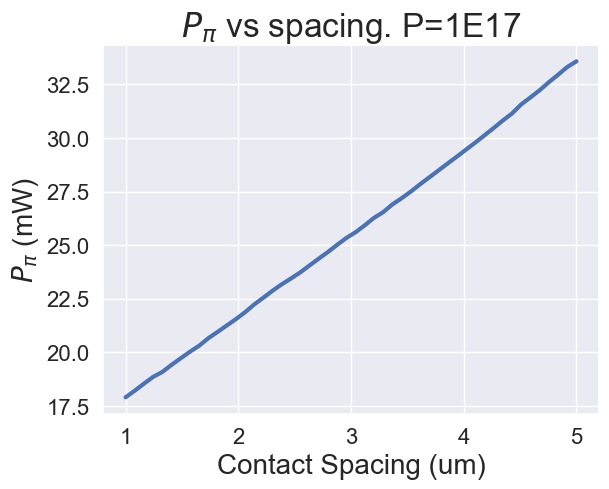

Text(0, 0.5, 'Insertion Loss (dB)')

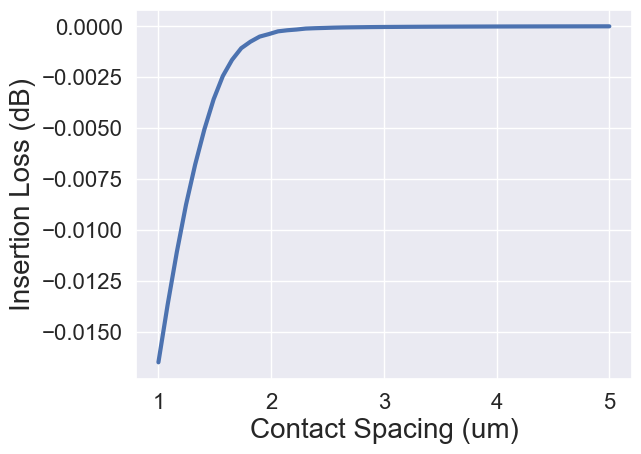

In [4]:
#Calculate insertion loss and Ppi vs spacing
Ppi_storage = []
loss_storage = []
for i in range(len(spacing_sweep)):
    neff_with_heat, neff0 = neff_storage_1E17[i]
    #Heating
    deltan = np.real(np.squeeze(neff_with_heat - neff0))
    #Calculate the Ppi for this heater
    L=200e-6 #200um assumed in simulation
    Lambda= 1550e-9
    deltaphi = 2*np.pi*deltan * L/Lambda
    Ppi = deltaP * np.pi/deltaphi
    Ppi_storage.append(Ppi)

    propagation = np.exp(1j*2*np.pi*np.squeeze(neff_with_heat)*L/Lambda)
    insertion_loss = np.real(propagation*np.conj(propagation))
    loss_storage.append(insertion_loss)

Ppi_storage = np.array(Ppi_storage)
loss_storage = np.array(loss_storage)

plt.figure()
plt.plot(spacing_sweep*1e6,Ppi_storage*1e3)
plt.title(r"$P_{\pi}$ vs spacing. P=1E17")
plt.xlabel("Contact Spacing (um)")
plt.ylabel(r"$P_{\pi}$ (mW)")
plt.show()

plt.figure()
plt.plot(spacing_sweep*1e6,10*np.log10(loss_storage))
plt.xlabel("Contact Spacing (um)")
plt.ylabel("Insertion Loss (dB)")

## Heater with 1E18 doping

In [5]:
spacing_sweep = np.linspace(1.0*um,5.0*um,num=50)
neff_storage_1E18 = []
for spacing in tqdm(spacing_sweep,desc='thermal sweep'):
    neff_with_heat,neff0 = doped_thermal_phase_shifter(contact_spacing=spacing,heater_doping=1e18)
    neff_storage_1E18.append((neff_with_heat,neff0))

thermal sweep: 100%|██████████| 50/50 [21:07<00:00, 25.35s/it]


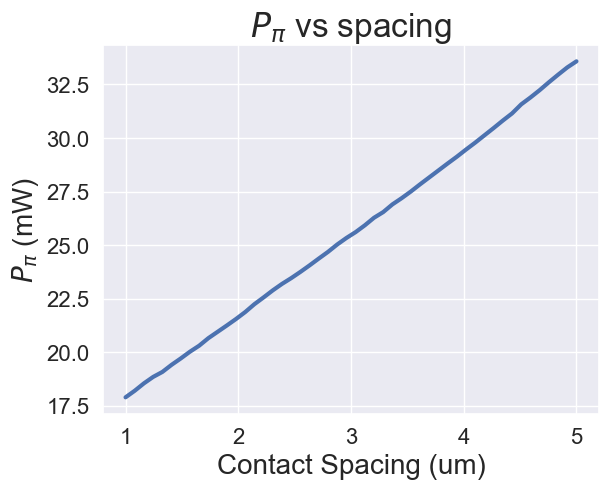

Text(0, 0.5, 'Insertion Loss (dB)')

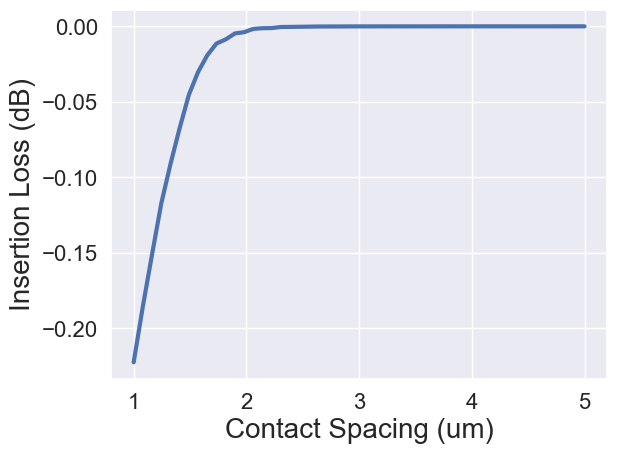

In [6]:
#Calculate insertion loss and Ppi vs spacing

Ppi_storage = []
loss_storage = []
for i in range(len(spacing_sweep)):
    neff_with_heat, neff0 = neff_storage_1E18[i]
    #Heating
    deltan = np.real(np.squeeze(neff_with_heat - neff0))
    #Calculate the Ppi for this heater
    L=200e-6 #200um assumed in simulation
    Lambda= 1550e-9
    deltaphi = 2*np.pi*deltan * L/Lambda
    Ppi = deltaP * np.pi/deltaphi
    Ppi_storage.append(Ppi)

    propagation = np.exp(1j*2*np.pi*np.squeeze(neff_with_heat)*L/Lambda)
    insertion_loss = np.real(propagation*np.conj(propagation))
    loss_storage.append(insertion_loss)

Ppi_storage = np.array(Ppi_storage)
loss_storage = np.array(loss_storage)

plt.figure()
plt.plot(spacing_sweep*1e6,Ppi_storage*1e3)
plt.title(r"$P_{\pi}$ vs spacing")
plt.xlabel("Contact Spacing (um)")
plt.ylabel(r"$P_{\pi}$ (mW)")
plt.show()

plt.figure()
plt.plot(spacing_sweep*1e6,10*np.log10(loss_storage))
plt.xlabel("Contact Spacing (um)")
plt.ylabel("Insertion Loss (dB)")

# Doped Silicon Thermal Phase Shifter with Undercut

In [7]:
# Thermal simulation: We heat both sides of the doped region with half of the total heat
um = 1e-6
deltaP = 0.0001

def doped_thermal_phase_shifter_undercut(
        contact_width = 1*um,
        contact_spacing = 4*um,
        metal_width = 0.2*um,
        heater_doping = 1e18,
        hide=True,
        save=False,
    ):
    dev1 = lumapi.DEVICE(filename="base_doped_heater_undercut.ldev",hide=hide)
    #Run sim with added heat
    dev1.switchtolayout()

    dev1.select("left_Al_contact")
    dev1.set("x min",-contact_spacing/2 - contact_width/2)
    dev1.set("x max",-contact_spacing/2 - contact_width/2 + metal_width)

    dev1.select("left_si_contact")
    dev1.set("x",-contact_spacing/2)
    dev1.set("x span",contact_width)

    dev1.select("right_Al_contact")
    dev1.set("x min",contact_spacing/2 + contact_width/2 - metal_width)
    dev1.set("x max",contact_spacing/2 + contact_width/2)

    dev1.select("right_si_contact")
    dev1.set("x",contact_spacing/2)
    dev1.set("x span",contact_width)

    dev1.select("partial")
    dev1.set("x span",contact_width + contact_spacing)

    dev1.select("CHARGE::left_heater")
    dev1.set("concentration",heater_doping*1e6) #1e6 for converting to m^(-3) which API wants
    dev1.set("x",-contact_spacing/2)
    dev1.set("x span",contact_width)

    dev1.select("CHARGE::right_heater")
    dev1.set("concentration",heater_doping*1e6) #1e6 for converting to m^(-3) which API wants
    dev1.set("x",contact_spacing/2)
    dev1.set("x span",contact_width)

    dev1.run("CHARGE")
    dev1.switchtolayout()

    dev1.select("HEAT::uniform heat left")
    dev1.set("total power",deltaP/2)

    dev1.select("HEAT::uniform heat right")
    dev1.set("total power",deltaP/2)

    dev1.run("HEAT")
    dev1.switchtolayout()
    if save == True:
        dev1.save("base_doped_heater.ldev")
    dev1.close()

    mode1 = lumapi.MODE(filename="base_doped_heater.lms",hide=True)
    mode1.switchtolayout()

    mode1.select("left_si_contact")
    mode1.set("x",-contact_spacing/2)
    mode1.set("x span",contact_width)

    mode1.select("right_si_contact")
    mode1.set("x",contact_spacing/2)
    mode1.set("x span",contact_width)

    mode1.select("partial")
    mode1.set("x span",contact_width + contact_spacing)

    mode1.select('temperature')
    mode1.importdataset("T.mat")

    mode1.select('np density')
    mode1.importdataset("doped_heater_charge.mat")

    mode1.setnamed('temperature','enabled',0)
    mode1.setanalysis('wavelength',1.55e-6)
    mode1.findmodes()
    mode1.selectmode(1)
    neff0 = mode1.getdata("FDE::data::mode1","neff")
    mode1.switchtolayout()
    mode1.setnamed('temperature','enabled',1)
    mode1.findmodes()
    mode1.selectmode(1)
    neff_with_heat = mode1.getdata("FDE::data::mode1","neff")
    mode1.switchtolayout()
    if save == True:
        mode1.save("base_doped_heater.lms")
    mode1.close()
    
    return neff_with_heat, neff0

In [8]:
spacing_sweep = np.linspace(1.0*um,5.0*um,num=50)
neff_storage_1E17 = []
for spacing in tqdm(spacing_sweep,desc='thermal sweep'):
    neff_with_heat,neff0 = doped_thermal_phase_shifter_undercut(contact_spacing=spacing,heater_doping=1e17)
    neff_storage_1E17.append((neff_with_heat,neff0))

storage_dict = {
    "spacing_sweep":spacing_sweep,
    "heater_doping":1e17,
    "deltaP": deltaP,
    "Lambda":1550e-9,
    "length":200e-6,
    "neff_storage":neff_storage_1E17,
}
with open("doped_heater_undercut_sweep.pkl",'wb') as f:
    pickle.dump(storage_dict,f)

thermal sweep: 100%|██████████| 50/50 [22:09<00:00, 26.59s/it]


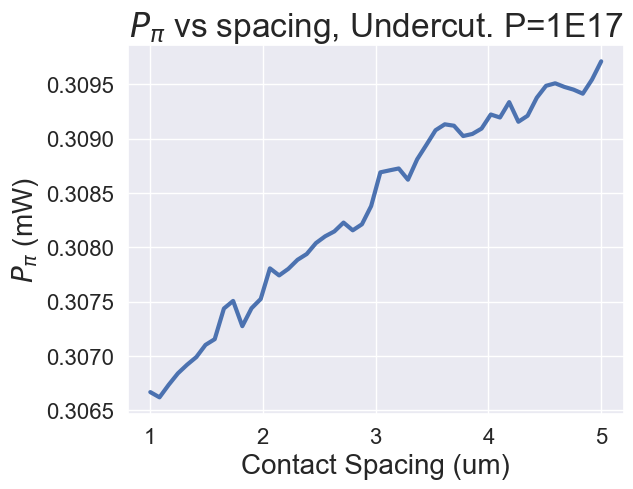

Text(0.5, 1.0, 'Insertion Loss vs Contact Spacing, Undercut. P=1E17')

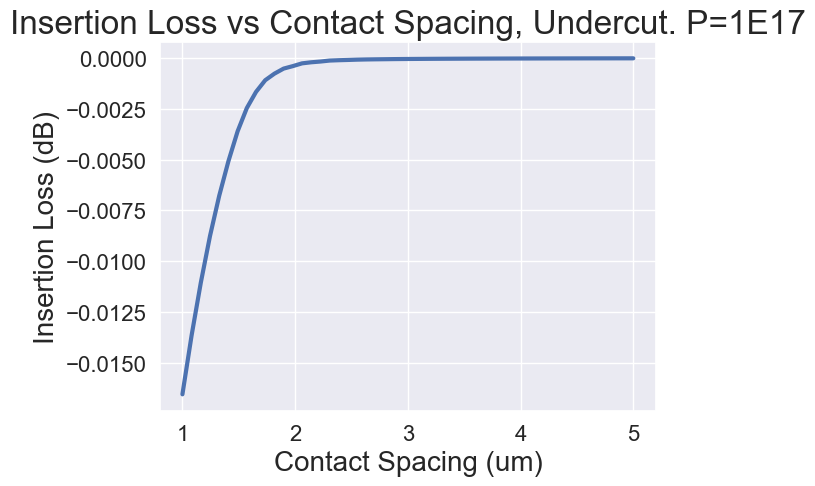

In [9]:
#Calculate insertion loss and Ppi vs spacing
Ppi_storage = []
loss_storage = []
for i in range(len(spacing_sweep)):
    neff_with_heat, neff0 = neff_storage_1E17[i]
    #Heating
    deltan = np.real(np.squeeze(neff_with_heat - neff0))
    #Calculate the Ppi for this heater
    L=200e-6 #200um assumed in simulation
    Lambda= 1550e-9
    deltaphi = 2*np.pi*deltan * L/Lambda
    Ppi = deltaP * np.pi/deltaphi
    Ppi_storage.append(Ppi)

    propagation = np.exp(1j*2*np.pi*np.squeeze(neff_with_heat)*L/Lambda)
    insertion_loss = np.real(propagation*np.conj(propagation))
    loss_storage.append(insertion_loss)

Ppi_storage = np.array(Ppi_storage)
loss_storage = np.array(loss_storage)

plt.figure()
plt.plot(spacing_sweep*1e6,Ppi_storage*1e3)
plt.title(r"$P_{\pi}$ vs spacing, Undercut. P=1E17")
plt.xlabel("Contact Spacing (um)")
plt.ylabel(r"$P_{\pi}$ (mW)")
plt.show()

plt.figure()
plt.plot(spacing_sweep*1e6,10*np.log10(loss_storage))
plt.xlabel("Contact Spacing (um)")
plt.ylabel("Insertion Loss (dB)")
plt.title("Insertion Loss vs Contact Spacing, Undercut. P=1E17")